In [1]:
from src import *

import numpy as np
import torch

import time

%matplotlib inline


# CUDA

In [2]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch is using', device)

PyTorch is using cuda


# Parameters

In [3]:
from configs import *

# Main

### Dataset

In [4]:
transforms = transforms.Compose([
    transforms.Resize(size=(resize_h, resize_w)),
    transforms.ToTensor(),    
])
dataset = CustomDataset(dataset_name=dataset_name, transforms=transforms)
train_loader = dataset.get_dataloader(is_train=True,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=num_workers,
                                      prefetch_factor=prefetch_factor)
test_loader = dataset.get_dataloader(is_train=False,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=num_workers,
                                     prefetch_factor=prefetch_factor)

### Model

In [5]:
input_dim = resize_h, resize_w, input_ch
model = VAE(input_dim, channels, num_z).to(device)
print(model)

criterion = ELBO(input_dim)
optimizer = optim.Adam(model.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: lr_decay ** epoch)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): GELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): GELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): GELU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): GELU()
    (14): Dropout(p=0.1, inplace=False)
    (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (16): GELU()
    (17): Dropout(p=0.1, inplace=False)
    (18): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mu): Linear(in_features=20480, out_features=1024, bias=True)
  (z_logvar): Linear(in_features=20480, out_features=1024, bia

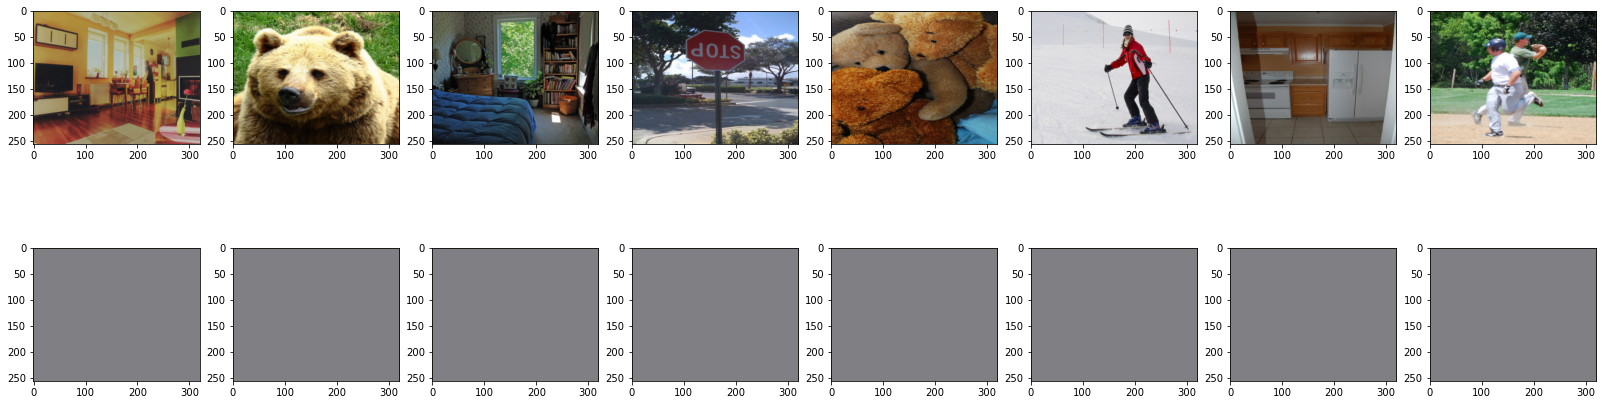

In [ ]:
# Learn
total_time = 0
train_losses = {"ELBO": []}
test_losses = {"ELBO": [], "MSE":[]}

for epoch in range(1, epochs + 1):
    # generate and visualize
    samples, recons = reconstruct(model, test_loader, device)
    visualize_imgs(samples, recons)
    
    # train
    start_time = time.time()
    train_loss = train(epoch,
                       model, train_loader,
                       criterion, optimizer, scheduler,
                       device)
    end_time = time.time()
    train_losses["ELBO"].append(train_loss)
    dt = end_time - start_time
    total_time += dt

    # test
    test_elbo_loss, test_mse_loss = test(epoch,
                                         model, test_loader,
                                         criterion,
                                         device)
    test_losses["ELBO"].append(test_elbo_loss)
    test_losses["MSE"].append(test_mse_loss)
    
    print(f'Epoch {epoch} / {epochs} in {dt:.2f} secs')
    print(f'Train loss[ELBO] {train_loss:.4f}, Test loss[ELBO] {test_elbo_loss:.4f}, Test loss[MSE] {test_mse_loss:.5f}')

print('Train loss[ELBO]:', train_losses["ELBO"])
print('Test loss[ELBO]:', test_losses["ELBO"])
print('Test loss[MSE]:', test_losses["MSE"])
print(f'Average {total_time / epochs:.2f} secs per epoch consumed')
print(f'Total {total_time:.2f} secs consumed')